In [1]:
# This is the model submitted for evaluation in the challenge
# %%
# from preprocessing import load_data, Salosensaari_processing
import matplotlib.pyplot as plt
import wandb
import os
import pickle
import random
import sys

from pipeline import postprocessing
from preprocessing import (
    CLINICAL_COVARIATES,
    Salosensaari_processing,
    clr_processing,
    load_data,
    taxa_selection,
)
from survival_models import CoxPH, sksurv_gbt, xgb_aft, xgb_optuna, xgbse_weibull

random.seed(10)

arguments = sys.argv


arguments = [0, '/home/tristan/Desktop/Repos/DreamHF']
ROOT = arguments[1]

print("Loading the data...")
pheno_df_train, pheno_df_test, readcounts_df_train, readcounts_df_test = load_data(
    ROOT)



/home/tristan/anaconda3/envs/DreamChallenge/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
<frozen importlib._bootstrap>:241: RuntimeWarning: sklearn.tree._criterion.Criterion size changed, may indicate binary incompatibility. Expected 328 from C header, got 528 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: sklearn.tree._splitter.Splitter size changed, may indicate binary incompatibility. Expected 1160 from C header, got 1360 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: sklearn.tree._criterion.ClassificationCriterion size changed, may indicate binary incompatibility. Expected 1168 from C header, got 1368 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: sklearn.tree._criterion.RegressionCriterion size changed, may indicate binary incompatibility. Ex

Loading the data...


In [4]:

models_list = ['sksurv_gbt', 'xgb_aft', 'xgb_optuna']
#%%
for model_name in models_list:
    config = dict(
        with_pca=False,
        n_components=None,
        # xgbse_weibull, sksurv_gbt, xgb_aft, xgb_optuna, CoxPH
        #  xgbse_weibull : not ok
        #  CoxPH : ok, sksurv_gbt : ok, xgb_aft: ok, but severe overfitting (0.9676036909132226, 0.6376541333063073)
        # xgb_optuna: ok , (0.8962962844422823,0.6261072261072261)
        model_name=model_name,
        clinical_covariates=CLINICAL_COVARIATES,
        processing='MI_clr',
        n_iter=10,
        n_taxa=0
    )

    run = wandb.init(
        project="Dream-Challenge",
        name=config['model_name'],
        notes="Compare models",
        tags=["baseline"],
        config=config,
        mode="disabled"  # disabled
    )

    # Load the data
    os.environ["root_folder"] = ROOT


    print("Processing the data...")


    wandb_config = wandb.config
    clinical_covariates = wandb_config.clinical_covariates

    #%%
    if wandb_config.processing == 'Salosensaari':
        X_train, X_test, y_train, y_test, test_sample_ids = Salosensaari_processing(
            pheno_df_train, pheno_df_test, readcounts_df_train, readcounts_df_test, clinical_covariates
        )
    elif wandb_config.processing == 'MI_clr':
        ## Feature selection
        X_train, X_test, y_train, y_test, test_sample_ids = clr_processing(
            pheno_df_train, pheno_df_test, readcounts_df_train, readcounts_df_test, clinical_covariates, wandb_config.n_taxa)

    model = eval(wandb_config.model_name +
                f'(with_pca = {wandb_config.with_pca}, n_components = {wandb_config.n_components})')

    # %%

    print("Search for optimal hyperparameters...")
    model = model.model_pipeline(X_train, y_train, wandb_config.n_iter)

    # %%
    preds_test = model.risk_score(X_test)
    postprocessing(preds_test, test_sample_ids, ROOT)


    plt.hist(preds_test)
    model.estimator[:1].transform(X_test)

    #%%
    model = model.evaluate(X_train, X_test, y_train, y_test)
    print(model.harrell_C_training)
    print(model.harrell_C_test)
    #%%
    wandb.log({'Harrel C - training':  model.harrell_C_training,
            'Harrel C - test':  model.harrell_C_test,
            'config':  config})
    #'HL - training': self.HL_training,
    #'HL - test': self.HL_test})

    wandb.run.summary['Harrel C - training'] = model.harrell_C_training
    wandb.run.summary['Harrel C - test'] = model.harrell_C_test

    # save the model to disk
    #filename = 'trained_model.sav'
    #pickle.dump(model, open(filename, 'wb'))

print("Task completed.")
run.finish()

# %%


Processing the data...
Search for optimal hyperparameters...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


<frozen importlib._bootstrap>:241: RuntimeWarning: sklearn.tree._criterion.Criterion size changed, may indicate binary incompatibility. Expected 328 from C header, got 528 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: sklearn.tree._splitter.Splitter size changed, may indicate binary incompatibility. Expected 1160 from C header, got 1360 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: sklearn.tree._criterion.ClassificationCriterion size changed, may indicate binary incompatibility. Expected 1168 from C header, got 1368 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: sklearn.tree._criterion.RegressionCriterion size changed, may indicate binary incompatibility. Expected 960 from C header, got 1160 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: sklearn.tree._criterion.Criterion size changed, may indicate binary incompatibility. Expected 328 from C header, got 528 from PyObject
<frozen importlib._bootstrap>:241: RuntimeW

[CV] END model__dropout_rate=0.5488135039273248, model__learning_rate=0.7151893663724195, model__loss=coxph, model__max_depth=4, model__max_leaf_nodes=29, model__min_samples_leaf=4, model__min_samples_split=9, model__n_estimators=109, model__subsample=0.8117818483929862; total time=  15.0s
[CV] END model__dropout_rate=0.5488135039273248, model__learning_rate=0.7151893663724195, model__loss=coxph, model__max_depth=4, model__max_leaf_nodes=29, model__min_samples_leaf=4, model__min_samples_split=9, model__n_estimators=109, model__subsample=0.8117818483929862; total time=  15.7s
[CV] END model__dropout_rate=0.5488135039273248, model__learning_rate=0.7151893663724195, model__loss=coxph, model__max_depth=4, model__max_leaf_nodes=29, model__min_samples_leaf=4, model__min_samples_split=9, model__n_estimators=109, model__subsample=0.8117818483929862; total time=  15.0s
[CV] END model__dropout_rate=0.5488135039273248, model__learning_rate=0.7151893663724195, model__loss=coxph, model__max_depth=4

/home/tristan/anaconda3/envs/DreamChallenge/lib/python3.10/site-packages/optuna/samplers/_tpe/sampler.py:281: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2022-12-21 19:59:59,952] A new study created in memory with name: no-name-f9004e63-ac28-48dd-af06-e99a31832485


0.09867959915888658
0.38554778554778557
Processing the data...
Search for optimal hyperparameters...


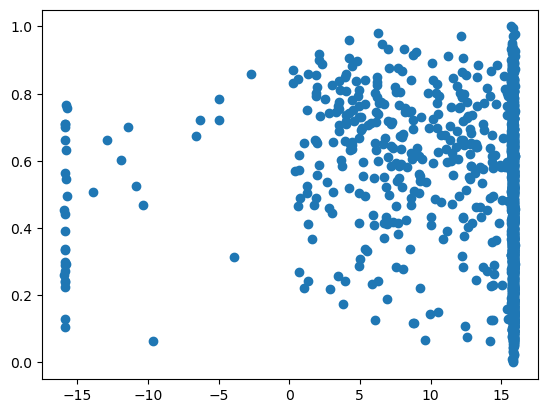

In [ ]:
plt.scatter(y_test['Event_time'], preds_test)

In [ ]:
FP = (preds_test['Event']==1) & (y_test['Event'] == 1)
FN = (preds_test['Event']==0) & (y_test['Event'] == 1)
TP = (preds_test['Event']==1) & (y_test['Event'] == 1)
TN = (preds_test['Event']==0) & (y_test['Event'] == 0)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
preds_test


array([0.7204593 , 0.75072396, 0.71096754, ..., 0.91003346, 0.42131436,
       0.56994677], dtype=float32)

In [ ]:
X_train.loc[FP,:]